In [39]:
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal, stats
import datetime as dt
import feather
from sklearn.metrics import roc_auc_score, roc_curve, r2_score, auc

In [40]:
results = feather.read_dataframe(r'../data/patient_HE.feather')

In [41]:
results

index patient      score_method  preds_test  test_Sz  cov_test_IEA  \
0      156716      HE  prop_time_corr_1    0.122415      1.0     -1.607781   
1      156717      HE  prop_time_corr_1    0.225356      0.0     -8.845800   
2      156718      HE  prop_time_corr_1    0.043388      1.0     11.760087   
3      156719      HE  prop_time_corr_1    0.039682      0.0     16.210657   
4      156720      HE  prop_time_corr_1    0.034010      0.0     18.130517   
...       ...     ...               ...         ...      ...           ...   
7918  1725444      HE  prop_time_corr_1    0.114908      0.0    -11.230680   
7919  1725445      HE  prop_time_corr_1    0.056292      0.0     -7.684344   
7920  1725446      HE  prop_time_corr_1    0.043913      1.0     -7.517758   
7921  1725447      HE  prop_time_corr_1    0.057871      0.0     -8.041379   
7922  1725448      HE  prop_time_corr_1    0.087071      0.0     -7.708164   

        time   cov_choice  
0        1.0   only_cross  
1        2.0   only_cross  
2        3.0   only_cross  
3        4.0   only_cross  
4        5.0   only_cross  
...      ...          ...  
7918  2637.0  phase_multi  
7919  2638.0  phase_multi  
7920  2639.0  phase_multi  
7921  2640.0  phase_multi  
7922  2641.0  phase_multi  

[7923 rows x 8 columns]

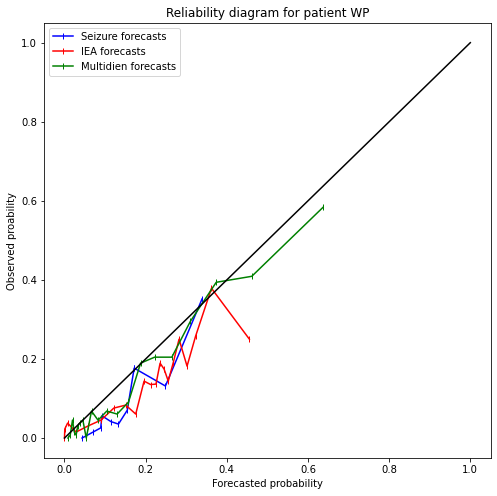

In [42]:
predictions_sz = results[(results['cov_choice']=='only_auto')]['preds_test'].to_numpy()
predictions_IEA = results[(results['cov_choice']=='only_cross')]['preds_test'].to_numpy()
predictions_multi = results[(results['cov_choice']=='phase_multi')]['preds_test'].to_numpy()
seizures = results[(results['cov_choice']=='only_cross')]['test_Sz'].to_numpy().astype('int')
bin_edges_sz = list(stats.mstats.mquantiles(predictions_sz, np.arange(0., 1., 0.05)))
bin_edges_IEA = list(stats.mstats.mquantiles(predictions_IEA, np.arange(0., 1., 0.05)))
bin_edges_multi = list(stats.mstats.mquantiles(predictions_multi, np.arange(0., 1., 0.05)))
fig, axs = plt.subplots(1, 1,figsize=(8, 8))
all_edges = [[0, *bin_edges_sz, 1], [0, *bin_edges_IEA, 1], [0, *bin_edges_multi, 1]]
lcolors = ['b', 'r', 'g']
labels = ['Seizure forecasts', 'IEA forecasts', 'Multidien forecasts']
for ipred, preds in enumerate([predictions_sz, predictions_IEA, predictions_multi]):
    bin_preds, bin_observed = [], []
    ledges= all_edges[ipred]
    for ixbin, xbin in enumerate(ledges[:-1]):
        curr_y = seizures[(preds>xbin) & (preds<=ledges[ixbin+1])]
        if curr_y.shape[0]>0:
            bin_observed.append(np.sum(curr_y)/curr_y.shape[0])
            bin_preds.append(np.mean(preds[(preds>xbin) & (preds<=ledges[ixbin+1])]))
    plt.plot(bin_preds, bin_observed, marker='|', color=lcolors[ipred], label=labels[ipred])
plt.plot([0, 1], [0, 1], 'k')
plt.xlabel('Forecasted probability')
plt.ylabel('Observed proability')
plt.title('Reliability diagram for patient HE')
plt.legend()